In [311]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from scikeras.wrappers import KerasClassifier
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import metrics
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, SimpleRNN, Reshape, GRU, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, mean_squared_error
from scipy.interpolate import interp1d
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from scipy.signal import resample
import shap
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse

In [312]:
folder_path = 'C:\\Users\\Administrator\\Documents\\TA\\dataset_feature_extracted\\'

In [313]:
train_folder = 'C:\\Users\\Administrator\\Documents\\TA\\dataset_feature_extracted\\training_set'
test_folder = 'C:\\Users\\Administrator\\Documents\\TA\\dataset_feature_extracted\\test_set'

Delete NaN Row

In [314]:
# def delete_nan_row(file_path):
#     df = pd.read_csv(file_path)

#     df = df.dropna()

#     df.to_csv(file_path, index=False)

# file_list = os.listdir(folder_path)

# for file_name in file_list:
#     if file_name.endswith('.csv'):
#         file_path = os.path.join(folder_path, file_name)
#         delete_nan_row(file_path)

# print("Proses selesai.")

Test Train Split

In [315]:
record_names = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', '230', '231', '232', '233', '234']

for record_name in record_names:
    df = pd.read_csv(f'C:\\Users\\Administrator\\Documents\\TA\\dataset_feature_extracted\\record_{record_name}.csv')
    df.head()

    unique_labels = df.iloc[:, -1].unique()
    print(record_name, unique_labels)

100 ['N' 'A' 'V']
101 ['N' 'A']
102 ['V' 'N']
103 ['N' 'A']
104 ['N' 'V']
105 ['N' 'V']
106 ['N' 'V']
107 ['V']
108 ['N' 'V' 'A' 'F']
109 ['L' 'F' 'V']
111 ['L' 'V']
112 ['N' 'A']
113 ['N' 'a']
114 ['N' 'V' 'J' 'F' 'A']
115 ['N']
116 ['N' 'V' 'A']
117 ['N' 'A']
118 ['R' 'V' 'A']
119 ['V' 'N']
121 ['N' 'A' 'V']
122 ['N']
123 ['N']
124 ['R' 'J' 'V' 'F' 'A']
200 ['V' 'N' 'A' 'F']
201 ['N' 'a' 'V' 'A' 'J' 'F']
202 ['N' 'V' 'A' 'a' 'F']
203 ['N' 'V' 'a']
205 ['N' 'V' 'F' 'A']
207 ['V' 'R' 'L' 'E' 'A']
208 ['V' 'F' 'N']
209 ['N' 'A' 'V']
210 ['N' 'F' 'V' 'a' 'E']
212 ['R' 'N']
213 ['N' 'F' 'A' 'V' 'a']
214 ['L' 'V' 'F']
215 ['N' 'V' 'A']
217 ['V' 'N']
219 ['N' 'V' 'F' 'A']
220 ['N' 'A']
221 ['N' 'V']
222 ['N' 'A' 'J']
223 ['N' 'V' 'A' 'F' 'a']
228 ['N' 'V' 'A']
230 ['N' 'V']
231 ['R' 'N' 'A']
232 ['R' 'A']
233 ['V' 'N' 'A' 'F']
234 ['N' 'J']


Split Train and Test Phase

In [316]:
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

dfs = []

for csv_file in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    df = pd.read_csv(file_path, header=None)

    dfs.append(df)

combined_data = pd.concat(dfs, ignore_index=True)

labels_to_eliminate = ['a', 'E', 'F', 'J']

filtered_data = combined_data[~combined_data.iloc[:, -1].isin(labels_to_eliminate)]

X = filtered_data.iloc[:, :-1] 
y = filtered_data.iloc[:, -1]

In [317]:
y.unique()

array(['A', 'N', 'V', 'L', 'R'], dtype=object)

In [318]:
le = LabelEncoder()
y = le.fit_transform(y)
y

array([0, 2, 2, ..., 2, 2, 2])

In [319]:
filtered_data

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,-0.062349,-0.059537,-0.055399,-0.050137,-0.044365,-0.037571,-0.030063,-0.021636,-0.013412,-0.005289,...,-0.001522,0.002985,0.007697,0.012204,0.016507,0.020197,0.022663,0.024108,0.024635,A
1,0.005020,0.005367,0.006225,0.007388,0.008346,0.009100,0.009752,0.010505,0.010952,0.010990,...,0.022188,0.025436,0.028786,0.031932,0.034975,0.037611,0.040144,0.041963,0.043578,N
2,-0.014524,-0.013170,-0.012224,-0.012094,-0.012678,-0.014384,-0.016906,-0.019734,-0.022051,-0.024061,...,0.019910,0.025521,0.030724,0.034804,0.037864,0.039700,0.040413,0.040106,0.038778,N
3,0.000127,-0.001334,-0.002896,-0.004865,-0.006834,-0.009414,-0.011586,-0.013349,-0.014805,-0.016056,...,0.017746,0.019151,0.019639,0.019821,0.018984,0.017535,0.016393,0.015558,0.014723,N
4,0.013770,0.014504,0.015136,0.015563,0.015480,0.014989,0.014294,0.012883,0.011065,0.008532,...,0.009466,0.013014,0.016153,0.018884,0.021105,0.023122,0.025138,0.026747,0.028355,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32013,-0.037304,-0.041972,-0.047252,-0.052430,-0.056179,-0.058907,-0.060207,-0.060385,-0.059644,-0.057882,...,-0.029948,-0.031462,-0.031753,-0.031330,-0.030602,-0.030181,-0.029761,-0.029750,-0.030453,N
32014,-0.011085,-0.017233,-0.024811,-0.033206,-0.041499,-0.048569,-0.053190,-0.055670,-0.056007,-0.054610,...,-0.040138,-0.042895,-0.044733,-0.045752,-0.046566,-0.047175,-0.047884,-0.048490,-0.048686,N
32015,-0.053734,-0.052726,-0.051410,-0.050399,-0.050102,-0.050926,-0.052565,-0.054815,-0.057370,-0.059822,...,-0.068684,-0.073565,-0.078343,-0.082203,-0.084021,-0.082981,-0.078982,-0.073656,-0.068635,N
32016,-0.057232,-0.057319,-0.058018,-0.060043,-0.063905,-0.068684,-0.073565,-0.078343,-0.082203,-0.084021,...,-0.066639,-0.071012,-0.074058,-0.075063,-0.074539,-0.072688,-0.070327,-0.068375,-0.067342,N


In [320]:
# Menghitung banyaknya masing-masing label
label_counts = np.bincount(y)

# Menampilkan hasil
for label, count in enumerate(label_counts):
    print(f'Label {label}: {count} occurrences')

Label 0: 2440 occurrences
Label 1: 8022 occurrences
Label 2: 9445 occurrences
Label 3: 6265 occurrences
Label 4: 4834 occurrences


In [321]:
for i in range(5):
    print(i, "=", le.inverse_transform([i]))

0 = ['A']
1 = ['L']
2 = ['N']
3 = ['R']
4 = ['V']


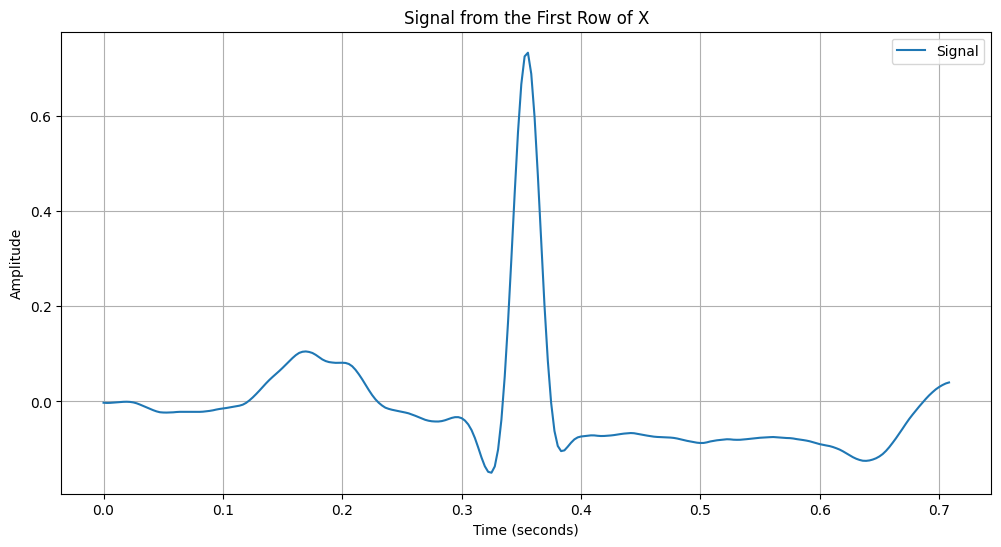

array([2])

In [322]:
signal_row = X.iloc[100, :].values
fs = 360

# Create a time axis based on the sampling frequency
time_axis = np.arange(0, len(signal_row)) / fs

# Plot the signal
plt.figure(figsize=(12, 6))
plt.plot(time_axis, signal_row, label='Signal')
plt.title('Signal from the Row of X')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

pd.DataFrame(y).iloc[100, :].values

In [359]:
type(signal_row)

numpy.ndarray

In [323]:
# def augment_data(signal, shift_factor=0.2, stretch_factor=0.5):
#     # Pergeseran
#     shift_amount = int(len(signal) * shift_factor)
#     shifted_signal = np.roll(signal, shift_amount)

#     # Pemanjangan dengan resampling
#     stretch_factor = 1 + stretch_factor
#     resampled_signal = resample(signal, int(len(signal) * stretch_factor))

#     return shifted_signal, resampled_signal

# for index, row in X.iterrows():
#     shifted_signal, stretched_signal = augment_data(row)
#     X = pd.concat([X, pd.DataFrame([shifted_signal, stretched_signal])], ignore_index=True)

# X

In [324]:
# X = X.transpose()

# fs = 360
# time_step = 1 / fs
# new_time = np.arange(0, len(X.columns) * time_step, time_step)

# interpolation_function = interp1d(X.index, X.values, kind='linear', axis=0, fill_value='extrapolate')

# new_values = interpolation_function(new_time)

# X = pd.DataFrame(new_values, columns=X.columns, index=new_time)

# print(X)

In [325]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,-0.062349,-0.059537,-0.055399,-0.050137,-0.044365,-0.037571,-0.030063,-0.021636,-0.013412,-0.005289,...,-0.006234,-0.001522,0.002985,0.007697,0.012204,0.016507,0.020197,0.022663,0.024108,0.024635
1,0.005020,0.005367,0.006225,0.007388,0.008346,0.009100,0.009752,0.010505,0.010952,0.010990,...,0.018429,0.022188,0.025436,0.028786,0.031932,0.034975,0.037611,0.040144,0.041963,0.043578
2,-0.014524,-0.013170,-0.012224,-0.012094,-0.012678,-0.014384,-0.016906,-0.019734,-0.022051,-0.024061,...,0.014605,0.019910,0.025521,0.030724,0.034804,0.037864,0.039700,0.040413,0.040106,0.038778
3,0.000127,-0.001334,-0.002896,-0.004865,-0.006834,-0.009414,-0.011586,-0.013349,-0.014805,-0.016056,...,0.015729,0.017746,0.019151,0.019639,0.019821,0.018984,0.017535,0.016393,0.015558,0.014723
4,0.013770,0.014504,0.015136,0.015563,0.015480,0.014989,0.014294,0.012883,0.011065,0.008532,...,0.004796,0.009466,0.013014,0.016153,0.018884,0.021105,0.023122,0.025138,0.026747,0.028355


In [326]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Classification Phase

In [327]:
num_classes = 5
input_shape = (256, 1)
epochs = 20
batch_size = 32

In [328]:
# def kfold_cross_validation(X, y, model, n_splits=5, epochs=1):
#     kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

#     X_array = np.array(X)
#     y_array = np.array(y)

#     precision_scores, recall_scores, f1_scores = [], [], []
#     accuracy_scores, rmse_scores = [], []

#     for fold, (train_indices, test_indices) in enumerate(kfold.split(X_array, y_array), 1):
#         print(f"Fold {fold}:")

#         # Split the data into train and test sets
#         X_train, X_test = X_array[train_indices], X_array[test_indices]
#         y_train, y_test = y_array[train_indices], y_array[test_indices]

#         # Clone the model to reset the weights for each fold
#         current_model = clone_model(model)
#         current_model.set_weights(model.get_weights())

#         # Compile the model
#         current_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#         # Train the model on the current fold
#         current_model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_test, y_test))

#         # Evaluate the model on the test set for this fold
#         eval_result = current_model.evaluate(X_test, y_test)
#         print(f"Validation Accuracy: {eval_result[1]*100:.2f}")

#         # Predictions
#         y_pred = current_model.predict(X_test).astype(int)

#         # Calculate precision, recall, and F1 score
#         precision = precision_score(y_test, y_pred, average='weighted')
#         recall = recall_score(y_test, y_pred, average='weighted')
#         f1 = f1_score(y_test, y_pred, average='weighted')

#         # Calculate accuracy
#         accuracy = accuracy_score(y_test, y_pred)

#         # Calculate RMSE
#         rmse = np.sqrt(mean_squared_error(y_test, y_pred))

#         precision_scores.append(precision)
#         recall_scores.append(recall)
#         f1_scores.append(f1)
#         accuracy_scores.append(accuracy)
#         rmse_scores.append(rmse)

#         print(f"Precision: {precision:.4f}")
#         print(f"Recall: {recall:.4f}")
#         print(f"F1 Score: {f1:.4f}")
#         print(f"Accuracy: {accuracy*100:.2f}")
#         print(f"RMSE: {rmse:.4f}\n")

#     # Calculate and print average metrics across folds
#     print("Average Metrics Across Folds:")
#     print(f"Average Precision: {np.mean(precision_scores):.4f}")
#     print(f"Average Recall: {np.mean(recall_scores):.4f}")
#     print(f"Average F1 Score: {np.mean(f1_scores):.4f}")
#     print(f"Average Accuracy: {np.mean(accuracy_scores)*100:.2f}")
#     print(f"Average RMSE: {np.mean(rmse_scores):.4f}")

In [329]:
def plot_training_history(history):
    # Plot training history
    plt.figure(figsize=(12, 6))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

#1 CLSTM

In [330]:
def create_cnn_lstm_model(input_shape, num_classes):
    model = Sequential()

    # Convolutional layers for feature extraction
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # Add a Dense layer before LSTM for additional complexity
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())

    # Reshape the output to 2D
    model.add(Reshape((-1, model.output_shape[-1])))

    # LSTM layers for sequence modeling
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(128))
    model.add(Dropout(0.5))

    # Flatten the output after the last LSTM layer
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model with adjusted learning rate
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


In [331]:
# class CustomKerasClassifier(KerasClassifier):
#     def __init__(self, filters1=32, kernel_size1=5, filters2=64, kernel_size2=5, lstm_units=50, dense_units=128, **kwargs):
#         self.filters1 = filters1
#         self.kernel_size1 = kernel_size1
#         self.filters2 = filters2
#         self.kernel_size2 = kernel_size2
#         self.lstm_units = lstm_units
#         self.dense_units = dense_units
#         super().__init__(**kwargs)

# def create_cnn_lstm_model_tuning(input_shape, filters1=32, kernel_size1=5, filters2=64, kernel_size2=5, lstm_units=50, dense_units=128, num_classes=num_classes):
#     model = Sequential()
#     model.add(Conv1D(filters=filters1, kernel_size=kernel_size1, activation='relu', input_shape=input_shape))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Conv1D(filters=filters2, kernel_size=kernel_size2, activation='relu'))
#     model.add(MaxPooling1D(pool_size=2))
#     model.add(Reshape((-1, model.output_shape[-1])))
#     model.add(LSTM(lstm_units, return_sequences=True))
#     model.add(LSTM(lstm_units))
#     model.add(Dense(dense_units, activation='relu'))
#     model.add(Dense(num_classes, activation='softmax'))
#     model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     return model

# keras_model_cnn_lstm_tuning = CustomKerasClassifier(build_fn=create_cnn_lstm_model_tuning, input_shape=input_shape, epochs=epochs, batch_size=batch_size, verbose=0)

# param_grid = {
#     'input_shape': [input_shape],  
#     'filters1': [32, 64, 128],
#     'kernel_size1': [3, 5, 7],
#     'filters2': [64, 128, 256],
#     'kernel_size2': [3, 5, 7],
#     'lstm_units': [50, 100, 150],
#     'dense_units': [64, 128, 256]
# }


In [332]:
cnn_lstm = create_cnn_lstm_model(input_shape, num_classes)
cnn_lstm.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_34 (Conv1D)          (None, 254, 128)          512       
                                                                 
 max_pooling1d_34 (MaxPooli  (None, 127, 128)          0         
 ng1D)                                                           
                                                                 
 conv1d_35 (Conv1D)          (None, 125, 256)          98560     
                                                                 
 max_pooling1d_35 (MaxPooli  (None, 62, 256)           0         
 ng1D)                                                           
                                                                 
 flatten_6 (Flatten)         (None, 15872)             0         
                                                                 
 dense_39 (Dense)            (None, 512)             

Epoch 1/20
776/776 [==============================] - 94s 114ms/step - loss: 0.2906 - accuracy: 0.9100 - val_loss: 0.1610 - val_accuracy: 0.9478
Epoch 2/20
776/776 [==============================] - 90s 115ms/step - loss: 0.1545 - accuracy: 0.9552 - val_loss: 0.1430 - val_accuracy: 0.9597
Epoch 3/20
776/776 [==============================] - 96s 123ms/step - loss: 0.1193 - accuracy: 0.9675 - val_loss: 0.0733 - val_accuracy: 0.9800
Epoch 4/20
776/776 [==============================] - 87s 112ms/step - loss: 0.0996 - accuracy: 0.9720 - val_loss: 0.0603 - val_accuracy: 0.9836
Epoch 5/20
776/776 [==============================] - 91s 118ms/step - loss: 0.0875 - accuracy: 0.9767 - val_loss: 0.0639 - val_accuracy: 0.9827
Epoch 6/20
776/776 [==============================] - 99s 128ms/step - loss: 0.0801 - accuracy: 0.9779 - val_loss: 0.0759 - val_accuracy: 0.9815
Epoch 7/20
776/776 [==============================] - 107s 138ms/step - loss: 0.0731 - accuracy: 0.9796 - val_loss: 0.0623 - val_a

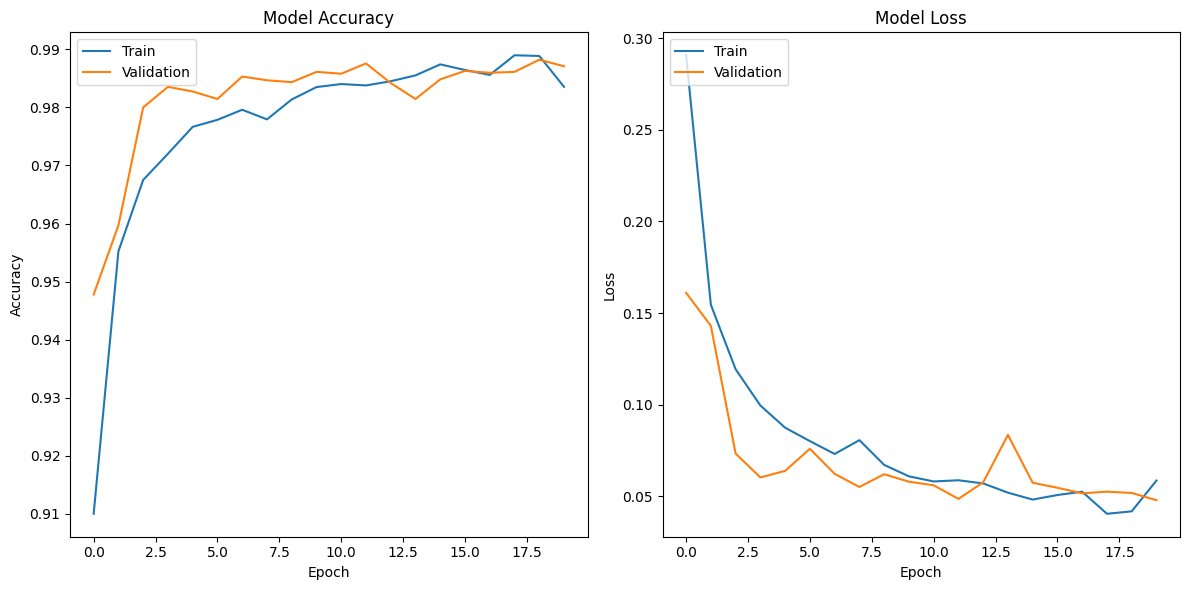

In [333]:
history = cnn_lstm.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

plot_training_history(history)

In [334]:
y_pred = cnn_lstm.predict(X_test)
y_pred_classes = y_pred.argmax(axis=-1)

# Menghitung dan mencetak akurasi
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

# Menghitung dan mencetak confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print('Confusion Matrix:')
print(conf_matrix)

# Menghitung dan mencetak classification report
class_report = classification_report(y_test, y_pred_classes)
print('Classification Report:')
print(class_report)


194/194 [==============================] - 5s 18ms/step
Accuracy: 0.9871
Confusion Matrix:
[[ 455    0   24    2    1]
 [   0 1560    0    0    2]
 [  11    4 1861    1   12]
 [   5    0    6 1252    2]
 [   1    3    6    0  994]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       482
           1       1.00      1.00      1.00      1562
           2       0.98      0.99      0.98      1889
           3       1.00      0.99      0.99      1265
           4       0.98      0.99      0.99      1004

    accuracy                           0.99      6202
   macro avg       0.98      0.98      0.98      6202
weighted avg       0.99      0.99      0.99      6202



In [335]:
# Menghitung dan mencetak precision
precision = precision_score(y_test, y_pred_classes, average='weighted')
print(f'Precision: {precision:.4f}')

# Menghitung dan mencetak sensitivity (recall)
sensitivity = recall_score(y_test, y_pred_classes, average='weighted')
print(f'Sensitivity (Recall): {sensitivity:.4f}')

# Menghitung dan mencetak F1 Score
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9871
Sensitivity (Recall): 0.9871
F1 Score: 0.9871


In [362]:
input_sample = X_test.iloc[9, :].values

# Menambahkan dimensi batch dan timestep
input_sample = input_sample.reshape((1, input_sample.shape[0], 1))

pred = cnn_lstm.predict(input_sample)
print(np.argmax(pred))
# print(pred)

predicted_class = le.inverse_transform([np.argmax(pred)])

print(predicted_class[0])


1/1 [==============================] - 0s 38ms/step
3
R


In [363]:
input_sample

array([[[ 0.05690749],
        [ 0.0639932 ],
        [ 0.06954845],
        [ 0.07245077],
        [ 0.07280222],
        [ 0.07131705],
        [ 0.06901568],
        [ 0.06620421],
        [ 0.06390305],
        [ 0.06333667],
        [ 0.06511732],
        [ 0.0680205 ],
        [ 0.07143395],
        [ 0.07474541],
        [ 0.07815897],
        [ 0.08045013],
        [ 0.08100663],
        [ 0.07972642],
        [ 0.07824214],
        [ 0.07675788],
        [ 0.07639607],
        [ 0.07654446],
        [ 0.07801936],
        [ 0.08082077],
        [ 0.08505072],
        [ 0.0896888 ],
        [ 0.09504112],
        [ 0.09906684],
        [ 0.10176598],
        [ 0.10303647],
        [ 0.10359259],
        [ 0.10384251],
        [ 0.10409232],
        [ 0.10434204],
        [ 0.10602021],
        [ 0.10963703],
        [ 0.1146823 ],
        [ 0.12044171],
        [ 0.12620098],
        [ 0.13226621],
        [ 0.13853537],
        [ 0.14511048],
        [ 0.15219561],
        [ 0

In [346]:
pd.DataFrame(y_test).iloc[9, :].values

array([3])

#2 CGRU

In [337]:
def create_cnn_gru_model(input_shape, num_classes):
    model = Sequential()

    # Convolutional layers for feature extraction
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # Add a Dense layer before GRU for additional complexity
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())

    # Reshape the output to 2D
    model.add(Reshape((-1, model.output_shape[-1])))

    # GRU layers for sequence modeling
    model.add(GRU(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(GRU(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(GRU(128))
    model.add(Dropout(0.5))

    # Flatten the output after the last GRU layer
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model with adjusted learning rate
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


In [338]:
cnn_gru = create_cnn_gru_model(input_shape, num_classes)
cnn_gru.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_36 (Conv1D)          (None, 254, 128)          512       
                                                                 
 max_pooling1d_36 (MaxPooli  (None, 127, 128)          0         
 ng1D)                                                           
                                                                 
 conv1d_37 (Conv1D)          (None, 125, 256)          98560     
                                                                 
 max_pooling1d_37 (MaxPooli  (None, 62, 256)           0         
 ng1D)                                                           
                                                                 
 flatten_8 (Flatten)         (None, 15872)             0         
                                                                 
 dense_42 (Dense)            (None, 512)             

Epoch 1/20
776/776 [==============================] - 88s 105ms/step - loss: 0.3458 - accuracy: 0.8939 - val_loss: 0.0939 - val_accuracy: 0.9719
Epoch 2/20
776/776 [==============================] - 84s 108ms/step - loss: 0.1602 - accuracy: 0.9546 - val_loss: 0.0927 - val_accuracy: 0.9745
Epoch 3/20
776/776 [==============================] - 86s 110ms/step - loss: 0.1313 - accuracy: 0.9639 - val_loss: 0.0850 - val_accuracy: 0.9763
Epoch 4/20
776/776 [==============================] - 82s 106ms/step - loss: 0.1112 - accuracy: 0.9692 - val_loss: 0.0766 - val_accuracy: 0.9792
Epoch 5/20
776/776 [==============================] - 89s 115ms/step - loss: 0.1001 - accuracy: 0.9723 - val_loss: 0.0665 - val_accuracy: 0.9816
Epoch 6/20
776/776 [==============================] - 85s 110ms/step - loss: 0.0810 - accuracy: 0.9772 - val_loss: 0.0668 - val_accuracy: 0.9805
Epoch 7/20
776/776 [==============================] - 88s 113ms/step - loss: 0.0828 - accuracy: 0.9781 - val_loss: 0.0551 - val_ac

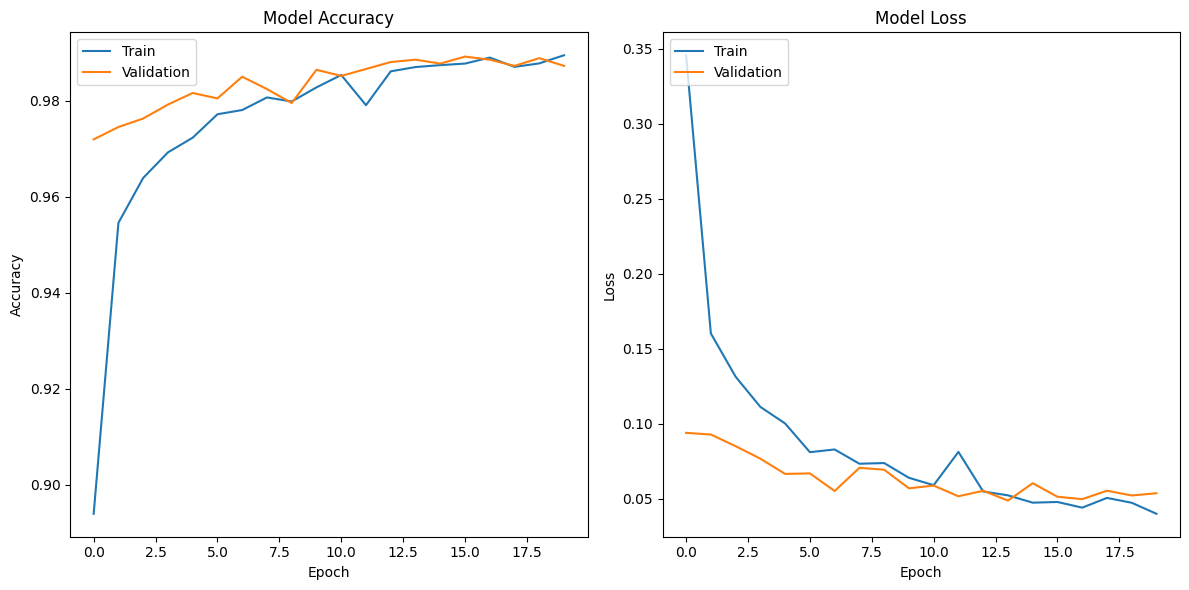

In [339]:
history = cnn_gru.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

plot_training_history(history)

In [340]:
y_pred = cnn_gru.predict(X_test)
y_pred_classes = y_pred.argmax(axis=-1)

# Menghitung dan mencetak akurasi
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

# Menghitung dan mencetak confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print('Confusion Matrix:')
print(conf_matrix)

# Menghitung dan mencetak classification report
class_report = classification_report(y_test, y_pred_classes)
print('Classification Report:')
print(class_report)

194/194 [==============================] - 4s 16ms/step
Accuracy: 0.9873
Confusion Matrix:
[[ 450    0   27    5    0]
 [   2 1553    1    1    5]
 [  12    1 1872    1    3]
 [   2    0    1 1262    0]
 [   2    4    9    3  986]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       482
           1       1.00      0.99      1.00      1562
           2       0.98      0.99      0.99      1889
           3       0.99      1.00      0.99      1265
           4       0.99      0.98      0.99      1004

    accuracy                           0.99      6202
   macro avg       0.98      0.98      0.98      6202
weighted avg       0.99      0.99      0.99      6202



In [341]:
# Menghitung dan mencetak precision
precision = precision_score(y_test, y_pred_classes, average='weighted')
print(f'Precision: {precision:.4f}')

# Menghitung dan mencetak sensitivity (recall)
sensitivity = recall_score(y_test, y_pred_classes, average='weighted')
print(f'Sensitivity (Recall): {sensitivity:.4f}')

# Menghitung dan mencetak F1 Score
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9872
Sensitivity (Recall): 0.9873
F1 Score: 0.9872


#3 CRNN

In [347]:
def create_cnn_rnn_model(input_shape, num_classes):
    model = Sequential()

    # Convolutional layers for feature extraction
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # Add a Dense layer before SimpleRNN for additional complexity
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())

    # Reshape the output to 2D
    model.add(Reshape((-1, model.output_shape[-1])))

    # SimpleRNN layers for sequence modeling
    model.add(SimpleRNN(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(SimpleRNN(128, return_sequences=True))
    model.add(Dropout(0.5))
    model.add(SimpleRNN(128))
    model.add(Dropout(0.5))

    # Flatten the output after the last SimpleRNN layer
    model.add(Flatten())

    # Fully connected layers
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model with adjusted learning rate
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


In [348]:
cnn_rnn = create_cnn_rnn_model(input_shape, num_classes)
cnn_rnn.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_40 (Conv1D)          (None, 254, 128)          512       
                                                                 
 max_pooling1d_40 (MaxPooli  (None, 127, 128)          0         
 ng1D)                                                           
                                                                 
 conv1d_41 (Conv1D)          (None, 125, 256)          98560     
                                                                 
 max_pooling1d_41 (MaxPooli  (None, 62, 256)           0         
 ng1D)                                                           
                                                                 
 flatten_12 (Flatten)        (None, 15872)             0         
                                                                 
 dense_48 (Dense)            (None, 512)             

Epoch 1/20
776/776 [==============================] - 89s 108ms/step - loss: 0.4327 - accuracy: 0.8658 - val_loss: 0.1553 - val_accuracy: 0.9544
Epoch 2/20
776/776 [==============================] - 85s 110ms/step - loss: 0.2122 - accuracy: 0.9396 - val_loss: 0.1319 - val_accuracy: 0.9657
Epoch 3/20
776/776 [==============================] - 77s 100ms/step - loss: 0.1681 - accuracy: 0.9506 - val_loss: 0.1112 - val_accuracy: 0.9737
Epoch 4/20
776/776 [==============================] - 83s 107ms/step - loss: 0.1385 - accuracy: 0.9617 - val_loss: 0.0790 - val_accuracy: 0.9776
Epoch 5/20
776/776 [==============================] - 79s 101ms/step - loss: 0.1132 - accuracy: 0.9678 - val_loss: 0.0830 - val_accuracy: 0.9777
Epoch 6/20
776/776 [==============================] - 90s 116ms/step - loss: 0.1004 - accuracy: 0.9715 - val_loss: 0.0778 - val_accuracy: 0.9805
Epoch 7/20
776/776 [==============================] - 78s 101ms/step - loss: 0.1057 - accuracy: 0.9721 - val_loss: 0.0866 - val_ac

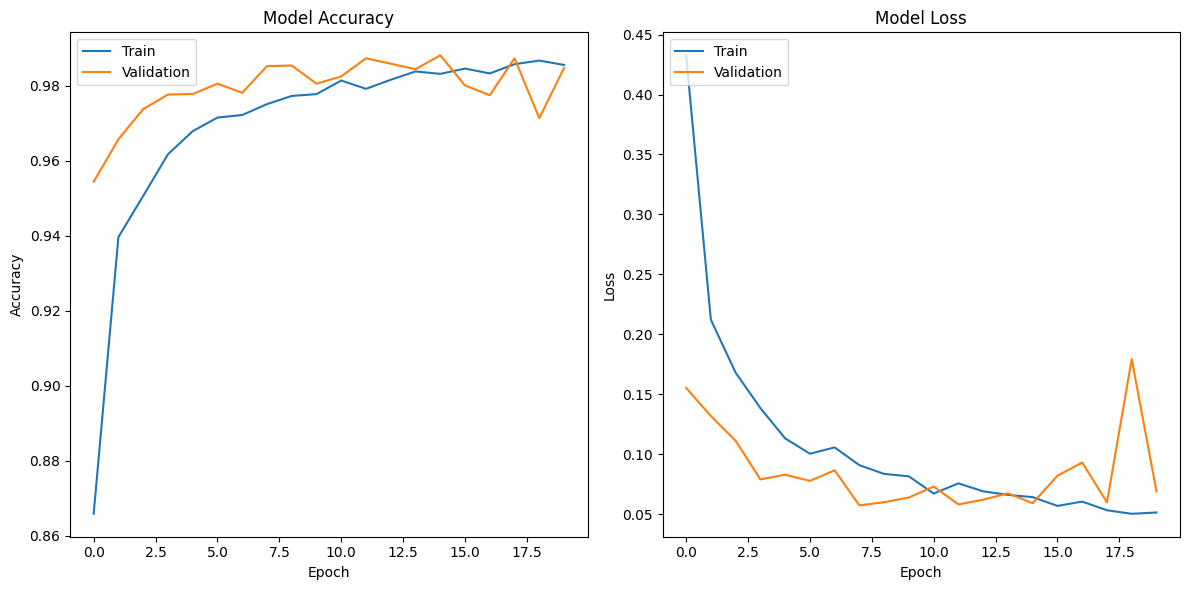

In [349]:
history = cnn_rnn.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

plot_training_history(history)

In [350]:
y_pred = cnn_rnn.predict(X_test)
y_pred_classes = y_pred.argmax(axis=-1)

# Menghitung dan mencetak akurasi
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy:.4f}')

# Menghitung dan mencetak confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
print('Confusion Matrix:')
print(conf_matrix)

# Menghitung dan mencetak classification report
class_report = classification_report(y_test, y_pred_classes)
print('Classification Report:')
print(class_report)

194/194 [==============================] - 3s 14ms/step
Accuracy: 0.9847
Confusion Matrix:
[[ 432    0   47    3    0]
 [   1 1550    3    0    8]
 [   4    2 1877    0    6]
 [   3    0    4 1258    0]
 [   3    4    7    0  990]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.93       482
           1       1.00      0.99      0.99      1562
           2       0.97      0.99      0.98      1889
           3       1.00      0.99      1.00      1265
           4       0.99      0.99      0.99      1004

    accuracy                           0.98      6202
   macro avg       0.98      0.97      0.98      6202
weighted avg       0.98      0.98      0.98      6202



In [351]:
# Menghitung dan mencetak precision
precision = precision_score(y_test, y_pred_classes, average='weighted')
print(f'Precision: {precision:.4f}')

# Menghitung dan mencetak sensitivity (recall)
sensitivity = recall_score(y_test, y_pred_classes, average='weighted')
print(f'Sensitivity (Recall): {sensitivity:.4f}')

# Menghitung dan mencetak F1 Score
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print(f'F1 Score: {f1:.4f}')

Precision: 0.9848
Sensitivity (Recall): 0.9847
F1 Score: 0.9845


#4 CAttention

In [352]:
# def create_cnn_attention_model(input_shape, num_classes):
#     model = Sequential()

#     # Convolutional layers for feature extraction
#     model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=input_shape))
#     model.add(MaxPooling1D(pool_size=2))

#     model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
#     model.add(MaxPooling1D(pool_size=2))

#     # Reshape the output to 2D
#     model.add(Reshape((-1, model.output_shape[-1])))

#     # Split the output into query and value
#     query_value = Dense(64, activation='relu')(model.output)

#     # Attention layer (manual implementation)
#     query = Dense(64, activation='relu')(query_value)
#     value = Dense(64, activation='relu')(query_value)
#     attention_scores = Attention()([query, value])

#     # Weighted sum of value using attention scores
#     attended_value = Dot(axes=(1, 1))([attention_scores, value])

#     # GRU layer for classification
#     lstm_output = LSTM(50, return_sequences=True)(attended_value)
#     lstm_output = LSTM(50)(lstm_output)

#     # Fully connected layer
#     dense_output = Dense(128, activation='relu')(lstm_output)
#     output = Dense(num_classes, activation='softmax')(dense_output)

#     # Create the model
#     model = Model(inputs=model.input, outputs=output)

#     # Compile the model
#     model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#     return model


In [353]:
# cnn_attention = create_cnn_attention_model(input_shape, num_classes)
# cnn_attention.summary()

In [354]:
# history = cnn_attention.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

# plot_training_history(history)

In [355]:
# y_pred = cnn_attention.predict(X_test)
# y_pred_classes = y_pred.argmax(axis=-1)

# # Menghitung dan mencetak akurasi
# accuracy = accuracy_score(y_test, y_pred_classes)
# print(f'Accuracy: {accuracy:.4f}')

# # Menghitung dan mencetak confusion matrix
# conf_matrix = confusion_matrix(y_test, y_pred_classes)
# print('Confusion Matrix:')
# print(conf_matrix)

# # Menghitung dan mencetak classification report
# class_report = classification_report(y_test, y_pred_classes)
# print('Classification Report:')
# print(class_report)

In [356]:
# # Menghitung dan mencetak precision
# precision = precision_score(y_test, y_pred_classes, average='weighted')
# print(f'Precision: {precision:.4f}')

# # Menghitung dan mencetak sensitivity (recall)
# sensitivity = recall_score(y_test, y_pred_classes, average='weighted')
# print(f'Sensitivity (Recall): {sensitivity:.4f}')

# # Menghitung dan mencetak F1 Score
# f1 = f1_score(y_test, y_pred_classes, average='weighted')
# print(f'F1 Score: {f1:.4f}')

Save Model

In [357]:
cnn_lstm.save('C:\\Users\\Administrator\\Documents\\TA\\cnn_lstm.h5')
cnn_gru.save('C:\\Users\\Administrator\\Documents\\TA\\cnn_gru.h5')
cnn_rnn.save('C:\\Users\\Administrator\\Documents\\TA\\cnn_rnn.h5')

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
